# DCGAN to generate images using CelebA dataset

## Import libraries

In [5]:
import tensorflow as tf
from tensorflow import keras, Tensor
from tensorflow.keras import layers, models, Model
import yaml
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import zipfile
import gdown 

## Prepare Data

In [8]:

# Set user and dataset information
USER = 'jessicali9530'
DATASET = 'celeba-dataset'

# Define the dataset path
data_path = 'celeba_gan'  # Ensure this matches the intended path
os.makedirs(data_path, exist_ok=True)

# Download the dataset
!kaggle datasets download -d {USER}/{DATASET} -p {data_path}

# Check if the zip file exists
dataset_zip_path = os.path.join(data_path, f'{DATASET}.zip')
if os.path.exists(dataset_zip_path):
    # Unzip the dataset
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_path)
    # Remove the zip file
    os.remove(dataset_zip_path)
    print('🚀 Done!')
else:
    print(f"Error: File '{dataset_zip_path}' not found. Please check if the dataset was downloaded correctly.")


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100%|█████████████████████████████████████▉| 1.33G/1.33G [05:03<00:00, 6.90MB/s]
100%|██████████████████████████████████████| 1.33G/1.33G [05:04<00:00, 4.70MB/s]
🚀 Done!


Found 202599 files.


I0000 00:00:1740276786.622692  364594 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740276786.646165  364594 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740276786.646323  364594 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740276786.646969  364594 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

sample.shape: (32, 64, 64, 3)


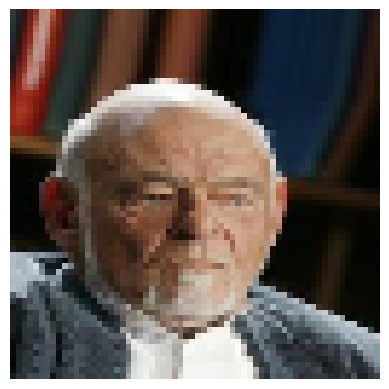

In [9]:
# create an image dataset
import yaml
# Load the config file
with open('./config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
batch_size= config['training']['batch_size']
input_shape = tuple(config['model']['input_shape'])

dataset= keras.preprocessing.image_dataset_from_directory ('celeba_gan', # path to images
                                                           label_mode=None, # no label
                                                           image_size=input_shape[:-1], # image size
                                                           batch_size=batch_size)
# normalizing the image
dataset = dataset.map(lambda x: x/255.0)
# show a sample
for sample in dataset:
    print(f'sample.shape: {sample.shape}')
    plt.axis("off") # turn off the axis label
    plt.imshow((sample.numpy() * 255).astype("int32") [0])
    break

# Deep Convolutional GAN model

In [10]:
# Hyper parameters
initial_feature_map = config['model']['initial_feature_map']
num_block = config['model']['num_block']


def conv_block (img: Tensor, filter: int , apply_batch : bool = True):
    x=layers.Conv2D(filters=filter, kernel_size=3, strides=2, padding='same')(img)
    if apply_batch:
        x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)  # Adjusted alpha to match common practice
    x = layers.Dropout(0.25)(x)  # shape: (batch, 64, H/2, W/2)
    return x
# Discriminator model
def Discriminator(input_shape: tuple= (64, 64, 3), initial_feature_map : int = 64, num_block : int = 4):
    ds_input = layers.Input(shape=input_shape)
    for idx  in range(num_block):
        if idx==0:
            x = conv_block (ds_input, initial_feature_map * (2**idx), apply_batch= False)
        else:
            x = conv_block (x, initial_feature_map * (2**idx), apply_batch= True)
    
    # Global Max Pooling
    x = layers.GlobalMaxPooling2D()(x)  # shape: (batch, 512)
    latent_dim =x.shape[-1]
    # Dense Layer
    dense_output = layers.Dense(1, activation='sigmoid')(x)
    
    # Create and return the model
    ds_model = Model(inputs=ds_input, outputs=dense_output)
    return ds_model, latent_dim

# Example usage
discriminator, latent_dim = Discriminator(input_shape = input_shape, initial_feature_map = initial_feature_map, num_block = num_block)
#discriminator.summary()

In [11]:
# Generator model
def upconv_block(x : Tensor, filters: int):
    """Defines an upsampling convolutional block with optional batch normalization."""
    x = layers.Conv2DTranspose(filters=filters, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.ReLU()(x)
    return x

def Generator(latent_dim: int,
               output_shape: tuple = (64, 64, 3), 
               initial_feature_map: int = 64, 
               num_block: int = 4):
    
    gen_input = layers.Input(shape=(latent_dim,))
    # reshape latent vector into small image
    x = layers.Dense(output_shape[0]// (2** num_block) * output_shape[1]// (2** num_block) * latent_dim)(gen_input)
    x=layers.Reshape((output_shape[0]// (2** num_block),
                      output_shape[1]// (2** num_block), 
                      latent_dim))(x)
    # Upsample through several blocks
    for idx in range(num_block):
        x = upconv_block (x , latent_dim// (2** (idx +1)) )    
    # Output layer to generate the final image
    x = layers.Conv2D(filters=output_shape[-1], kernel_size=3, strides=1, padding='same', activation='sigmoid')(x)
    gen_model = Model(inputs= gen_input, outputs = x)
    return gen_model
generator = Generator(latent_dim, input_shape, initial_feature_map, num_block)
#generator.summary()       

In [12]:
# DCGAN model
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super (DCGAN, self).__init__()
        self.discriminator= discriminator
        self.generator = generator
        self.latent_dim = int(latent_dim)
        print(f'int(latent_dim): {self.latent_dim}')
    def compile(self, ds_optimizer, gen_optimizer, loss_fn):
        super (DCGAN, self).compile()
        self.ds_optimizer = ds_optimizer
        self.gen_optimizer = gen_optimizer
        self.loss_fn = loss_fn
        self.ds_loss_metric = keras.metrics.Mean(name = 'ds_loss')
        self.gen_loss_metric = keras.metrics.Mean(name = 'gen_loss')
    @property
    def metrics(self):
        return [self.ds_loss_metric, self.gen_loss_metric]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake images using the random selected points from the latent space
        generated_images = self.generator(random_latent_vectors, training=True)

        # Concatenate them with the real images
        real_fake_images = tf.concat([generated_images, real_images], axis=0)

        # Labels -> fake images: 1, real images: 0
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Add random noise to labels to increase model stability
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as ds_tape:
            predictions = self.discriminator(real_fake_images, training=True)
            ds_loss = self.loss_fn(labels, predictions)

        grads_of_discriminator = ds_tape.gradient(ds_loss, self.discriminator.trainable_weights)
        self.ds_optimizer.apply_gradients(zip(grads_of_discriminator, self.discriminator.trainable_weights))
        self.ds_loss_metric.update_state(ds_loss)

        # Train the Generator
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as gen_tape:
            fake_predictions = self.discriminator(self.generator(random_latent_vectors, training=True))
            gen_loss = self.loss_fn(misleading_labels, fake_predictions)

        grads_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_weights)
        self.gen_optimizer.apply_gradients(zip(grads_of_generator, self.generator.trainable_weights))
        self.gen_loss_metric.update_state(gen_loss)

        return {
            "ds_loss": self.ds_loss_metric.result(),
            "gen_loss": self.gen_loss_metric.result(),
        }

# Save Generated images and Train the Model

In [13]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img = 5, latent_dim = 512, save_path='./generated_images'):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_path = save_path  # Add this line to initialize save_path
    def on_epoch_end (self, epoch, logs= None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_imgs = self.model.generator(random_latent_vectors)
        generated_imgs *=255
        generated_imgs.numpy()
        for i in range (self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_imgs[i])
            img.save(f'{self.save_path}/generated_img_{epoch}_{i}.png')

# Train DCGAN model

In [8]:
epochs = config['training']['epochs']
ds_optimizer = tf.keras.optimizers.Adam(learning_rate=config['training']['learning_rate'])
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=config['training']['learning_rate'])
loss_fn = tf.keras.losses.BinaryCrossentropy()
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
dcgan.compile(ds_optimizer=ds_optimizer, gen_optimizer=gen_optimizer, loss_fn=loss_fn)
dcgan.fit(dataset, 
          epochs=epochs, 
          callbacks=[GANMonitor(num_img = config['training']['num_generated_img'], 
                                latent_dim= latent_dim, 
                                save_path=config['save']['generated_image_path']
                                )
                     ]
          )

int(latent_dim): 512
Epoch 1/200


I0000 00:00:1723359231.269092   50123 service.cc:146] XLA service 0x7efe90024e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723359231.269169   50123 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-08-11 02:53:51.361770: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-11 02:53:51.469001: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
2024-08-11 02:53:51.848903: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   3/6332 ━━━━━━━━━━━━━━━━━━━━ 5:38 53ms/step - ds_loss: 1.0864 - gen_loss: 0.7660 

I0000 00:00:1723359240.554818   50123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6332/6332 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - ds_loss: -0.3366 - gen_loss: 49.4476

W0000 00:00:1723359378.005730   49970 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723359378.016825   49970 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723359378.018662   49970 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723359378.020447   49970 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723359378.022459   49970 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723359378.027360   49970 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723359378.029548   49970 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723359378.031336   49970 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723359378.033256   49970 gp

6332/6332 ━━━━━━━━━━━━━━━━━━━━ 151s 22ms/step - ds_loss: -0.3366 - gen_loss: 49.4490
Epoch 2/200
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 129s 20ms/step - ds_loss: -0.0183 - gen_loss: 38.5472
Epoch 3/200
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 129s 20ms/step - ds_loss: -0.3301 - gen_loss: 89.7151
Epoch 4/200
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 129s 20ms/step - ds_loss: 0.0035 - gen_loss: 59.9632
Epoch 5/200
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 140s 22ms/step - ds_loss: 0.0695 - gen_loss: 32.7955
Epoch 6/200
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 138s 22ms/step - ds_loss: 0.0875 - gen_loss: 20.5054
Epoch 7/200
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 161s 25ms/step - ds_loss: 0.0776 - gen_loss: 18.0487
Epoch 8/200
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 161s 26ms/step - ds_loss: 0.0882 - gen_loss: 13.8920
Epoch 9/200
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 160s 25ms/step - ds_loss: 0.1155 - gen_loss: 10.4519
Epoch 10/200
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 160s 25ms/step - ds_loss: 0.1436 - gen_loss: 7.8985
Epoch 11/200
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 156s 